In [146]:
import tensorflow as tf
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
from datetime import datetime, timedelta
import talib
import numpy as np
import data as ds
import os

In [147]:
pd.options.mode.chained_assignment = None

In [148]:
file_1 = os.path.abspath(os.path.join('data', 'nq', '20201020_064100.csv'))
file_2 = os.path.abspath(os.path.join('data', 'nq', '20201023_064200.csv'))
df1 = pd.read_csv(file_1)
df2 = pd.read_csv(file_2)

In [149]:
# 1.0 reshapre dataframe 重構數據集
df1.index = pd.to_datetime(df1.stime)
df2.index = pd.to_datetime(df2.stime)
df3 = pd.concat([df1, df2], axis=0, join='outer', ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True)
df3 = df3.rename(columns={"high": "High", "low": "Low", "open": "Open", "last": "Close", "vol": "Accumulated Volume"})
df3['udate'] = pd.to_datetime(df3['udate'])
df3['udate2'] = [v.date() for v in df3['udate'].tolist()]
df3['udate2'] = pd.to_datetime(df3['udate2'])
df3['interactive_udate'] = pd.to_datetime(df3['interactive_udate'])
df3['mdate'] = pd.to_datetime(df3['mdate'])
df3['stime'] = pd.to_datetime(df3['stime'])
# 1.1 data validation 數據有效性檢查
shape = df3.shape
types = df3.dtypes
types1 = {'High': 'float64', 'Low': 'float64', 'Open': 'float64', 'Close': 'float64', 'Accumulated Volume': 'int64', 'chng': 'float64', 'pchng': 'float64'}
df3.astype(types1).dtypes
# 1.2 zero / nan
for k, v in types1.items():
    if (df3[k].isin([np.nan]).any().any()):
        print(k+' obtains nan')
    if (df3[k].isin([0]).any().any()):
        print(k+' obtains 0')

chng obtains 0
pchng obtains 0


In [150]:
# 2.0 technical indicator
highs = np.array(df3['High'], dtype='float')
lows = np.array(df3['Low'], dtype='float')
opens = np.array(df3['Open'], dtype='float')
closes = np.array(df3['Close'], dtype='float')
# 2.1 SMA
for v in [5, 10, 20, 50, 100, 200]:
    df3['sma-'+str(v)]= talib.SMA(closes, timeperiod=v)
# 2.2 Bollinger
df3['upper-band'], df3['middle-band'], df3['lower-band'] = talib.BBANDS(closes, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
# 2.3 P-SAR
df3['p-sar'] = talib.SAR(highs, lows, acceleration=0.02, maximum=0.2)

In [151]:
# 3.0 separate by daily
data = {}
days1 = list(dict.fromkeys(df3['udate2'].tolist())) # how many tradeing day
for day in days1:
    day_start = datetime(day.year, day.month, day.day, 6, 0, 0)
    day2 = day + timedelta(days=1)
    day_end = datetime(day2.year, day2.month, day2.day, 6, 0, 0)
    mask = ((df3['udate'] >= day_start) & (df3['udate'] <= day_end))
    df4 = df3.loc[mask]
    if (df4.shape[0] > 1):
        # 3.1 calculate vol by minute
        df4['Volume'] = df4['Accumulated Volume'].diff()
        # 3.2 OBV
        closes = np.array(df4['Close'], dtype='float')
        vols = np.array(df4['Volume'], dtype='float')
        df4['obv'] = talib.OBV(closes, vols)
        # 3.3 vol EMA
        df4['vol-sma5'] = talib.EMA(vols, timeperiod=5)
        # 3.4
        data[day] = df4

2020-10-23 00:00:00 (1415, 50) 2020-10-12 06:10:04 2020-10-13 05:44:03


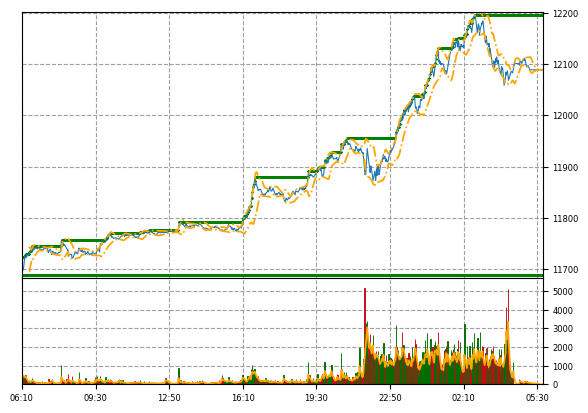

2020-10-23 00:00:00 (1414, 50) 2020-10-13 06:10:03 2020-10-14 05:44:03


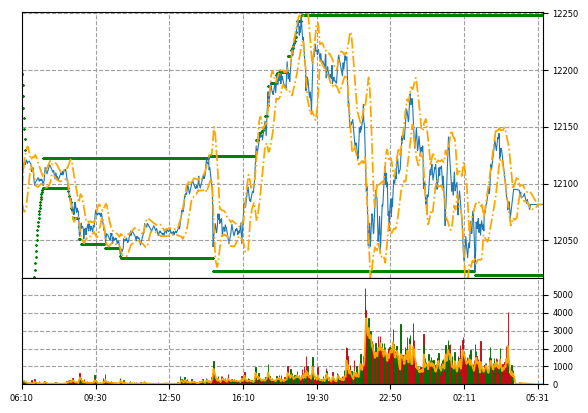

2020-10-23 00:00:00 (1412, 50) 2020-10-14 06:10:04 2020-10-15 05:44:03


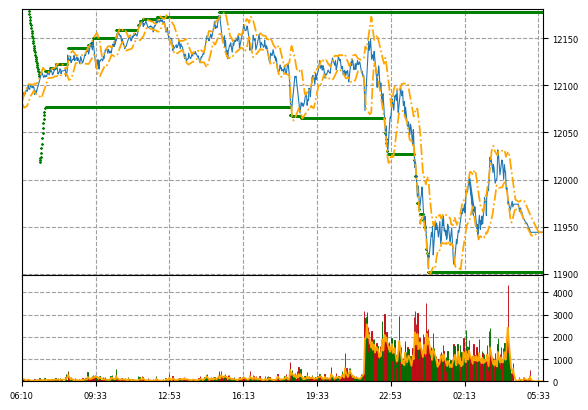

2020-10-23 00:00:00 (1415, 50) 2020-10-15 06:10:03 2020-10-16 05:44:03


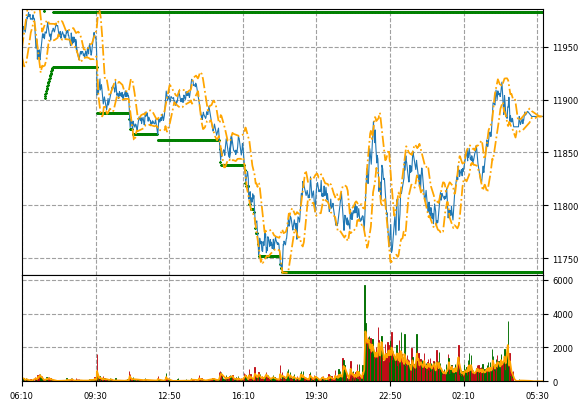

2020-10-23 00:00:00 (1429, 50) 2020-10-16 06:10:03 2020-10-17 05:59:03


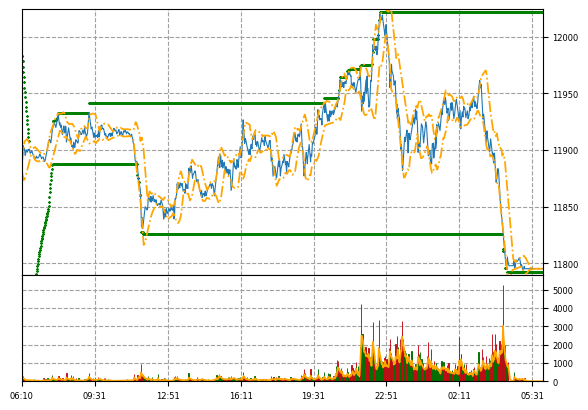

2020-10-23 00:00:00 (1415, 50) 2020-10-19 06:10:04 2020-10-20 05:25:04


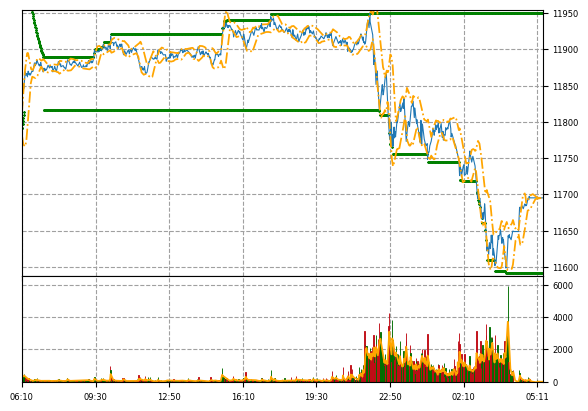

2020-10-23 00:00:00 (1415, 50) 2020-10-20 06:10:03 2020-10-21 05:44:04


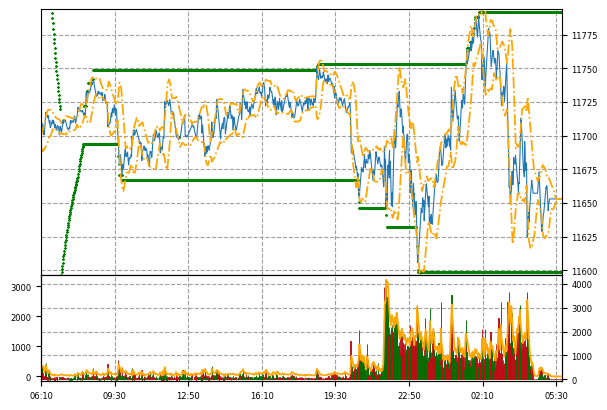

2020-10-23 00:00:00 (1414, 50) 2020-10-21 06:10:04 2020-10-22 05:44:03


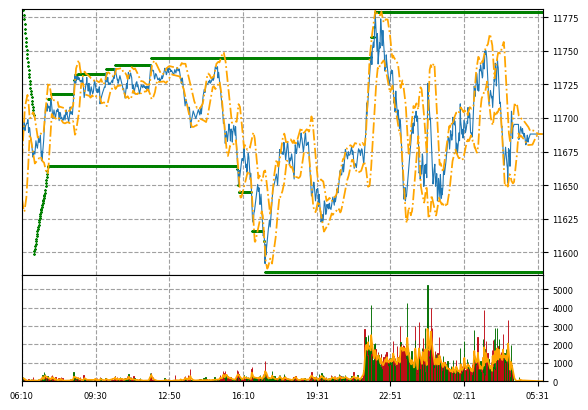

2020-10-23 00:00:00 (1415, 50) 2020-10-22 06:10:04 2020-10-23 05:44:03


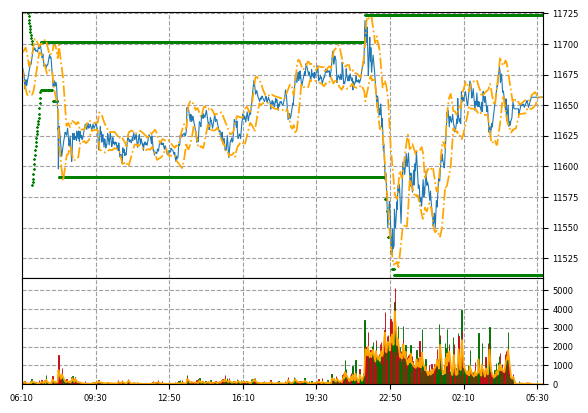

2020-10-23 00:00:00 (524, 50) 2020-10-23 06:10:03 2020-10-23 14:53:04


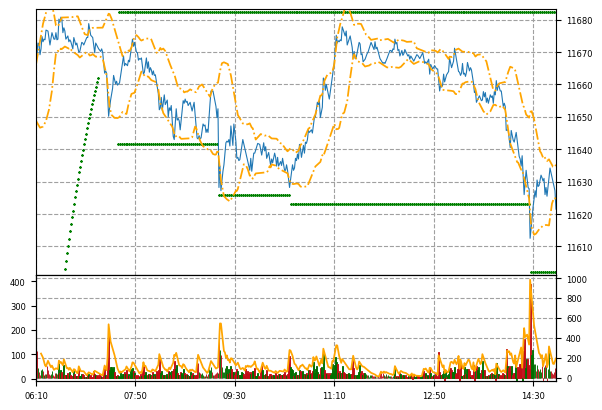

In [152]:
# 4.0 draw candle chart
for k, df5 in data.items():
    print(day, df5.shape, df5['udate'].iloc[0], df5['udate'].iloc[-1])
    # 4.1 style
    style = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size':6})
    # 4.2 addplot
    apds = [mpf.make_addplot(df5[['lower-band','upper-band']],panel=0,color='orange',linestyle='dashdot'),
            mpf.make_addplot(df5['p-sar'],scatter=True,markersize=1,marker='*',panel=0,color='green'),
            mpf.make_addplot((df5['vol-sma5']),panel=1,color='orange')]
    # 4.3 render
    mpf.plot(df5, type='line', style=style, ylabel='', ylabel_lower='', volume=True, figscale=0.75, xrotation=0, datetime_format="%H:%M", show_nontrading=False, tight_layout=True, addplot=apds)